In [15]:
import getpass
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

edm_address = getpass.getpass(prompt='EDM server address: ')

print('\nEDM login information')
edm_name = getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)

%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

# Delete the credential variables for security purpose.
del edm_name, edm_password


EDM login information
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [16]:
%reload_ext sql

In [17]:
# returns the list of transformers downstream of a given transformer
def get_dt_tr(transformer_id):
    dt_sql = %sql   SELECT grid_element_id AS g_id\
                        FROM grid_get_downstream('awefice', :transformer_id, false) \
                        WHERE type = 'Transformer';
    
    if pd.DataFrame(dt_sql).shape[0] != 0:
    
        return pd.DataFrame(dt_sql)['g_id'].tolist()
    
    else:
        return []

In [18]:
# returns the list of meters downstream of a given transformer
def get_dt_mt(transformer_id):
    dt_sql = %sql   SELECT grid_element_id AS g_id\
                        FROM grid_get_downstream('awefice', :transformer_id, false) \
                        WHERE type = 'Meter';
    
    if pd.DataFrame(dt_sql).shape[0] != 0:
        return pd.DataFrame(dt_sql)['g_id'].tolist()
    
    else:
        return []

In [19]:
#returns the phase of a transformer
def get_phase_tr(transformer_id):
    phases_sql = %sql SELECT ge.phases \
                        FROM grid_element ge \
                        WHERE ge.grid_element_id = :transformer_id;

    phases = pd.DataFrame(phases_sql)['phases'][0]
    return phases

In [20]:
#returns the secondary voltage of a transformer
def get_secondary_voltage(transformer_id):
    meta_sql = %sql SELECT meta_data.key, meta_data.value \
                        FROM grid_element ge \
                        JOIN json_each_text(ge.meta::json) meta_data \
                            ON true \
                        WHERE ge.grid_element_id = :transformer_id \
                            AND (meta_data.key = 'secondary_voltage');
    
    meta = meta_sql.DataFrame().set_index('key')
    
    return float(meta.loc['secondary_voltage','value'])

In [21]:
#returns the ratings_kva of a transformer
def get_ratings_kva(transformer_id):
    meta_sql = %sql SELECT meta_data.key, meta_data.value \
                        FROM grid_element ge \
                        JOIN json_each_text(ge.meta::json) meta_data \
                            ON true \
                        WHERE ge.grid_element_id = :transformer_id \
                            AND meta_data.key = 'rating_kva';
    
    meta = meta_sql.DataFrame().set_index('key')
    
    return float(meta.loc['rating_kva','value'])

In [22]:
#returns the phase of a meter
def get_phase_mt(meter_id):
    phases_sql = %sql SELECT ge.phases \
                        FROM grid_element ge \
                        WHERE ge.grid_element_id = :meter_id;

    phases = pd.DataFrame(phases_sql)['phases'][0]
    return phases

In [23]:
# from cmath import phase

def meter_timeseries(meters, start_date, end_date):
    '''Takes a list of grid elements and returns their loads as a timeseries dataframe, one column (kWh) for each meter.
    
                 Parameters:
                         meters (List of strings): list of grid_element_ids of all meters to aggregate
                         transformer_data (List of DataFrames): list of pandas databases containing the aggregated 
                                                                     data for connected transformers
                                                                     
                                                                     Dataframes will contain 3 columns:
                                                                         timestamp
                                                                         load in kWh
                                                                         
                         start_date (String): start date of time series range
                         end_date (String): end date of time series range
    
    '''
    
    #get meter data
    
    meter_data = []
    
    timestamp_data = None
    
    for meter in meters:
        meter_data_sql = %sql SELECT tdss.timestamp AS timestamp, geds.grid_element_id AS g_id, \
                                    MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V, \
                                    MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh \
                                FROM grid_element ge \
                                JOIN grid_element_data_source geds \
                                    ON geds.grid_id = ge.grid_id \
                                    AND geds.grid_element_id = ge.grid_element_id \
                                JOIN UNNEST(geds.metrics::TEXT[]) metric_key \
                                    ON true \
                                JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss \
                                    ON true \
                                WHERE ge.grid_id = 'awefice' \
                                    AND ge.type = 'Meter' \
                                    AND ge.grid_element_id = :meter \
                                GROUP BY tdss.timestamp, geds.grid_element_id \
                                ORDER BY 1, 2;
        
        
        this_meter = pd.DataFrame(meter_data_sql)
            
        if timestamp_data is None:
            timestamp_data = pd.DataFrame(this_meter['timestamp'])
    
        this_meter[meter] = this_meter['kwh']
        this_meter.set_index('timestamp')

        #only keep the columns for timestamp and load
        meter_data.append(this_meter[[meter]])

    if timestamp_data is None:
        raise Exception('No time series data was found for elements downstream of this transformer.')
    
    # create a dataframe with columns having timeseries data for the meters
    df_meters = timestamp_data.join(meter_data).set_index('timestamp')

    return df_meters

In [24]:
# returns the aggregate load of a given transformer (we will mostly apply this function on distribution transformers)

def transformer_aggregate(transformer_id, pf, start_date, end_date):
    ''' Takes transformer_id, returns dataframe with aggregated load time series for
        times between start_date and end_date.
    
            Parameters:
                transformer_id (String): grid_element_id of transformer
                pf (float): power factor (between 0 and 1, usually 0.8-1)
                start_date (String): start date of time series range
                end_date (String): end date of time series range
    '''
        
    #collect all meters on this transformer and aggregate on them.
    
    meters = get_dt_mt(transformer_id)

    #get secondary voltage and ratings kVA of transformer
    sec_voltage = get_secondary_voltage(transformer_id)
    ratings_kva = get_ratings_kva(transformer_id)

    #get the phase of the transformer
    tr_phase = get_phase_tr(transformer_id)
    
    #get the timeseries data for allm the downstream meters
    df_meters = meter_timeseries(meters, start_date, end_date)
    
    #create a new dataframe to save the agg load
    agg_load = df_meters

    load = np.zeros(df_meters.shape[0])

    for meter in meters:
        load += df_meters[meter]
    
    agg_load['load'] = load
    agg_load['excess'] = ratings_kva*pf - agg_load['load']
    return agg_load[["load", "excess"]]

In [25]:
from math import ceil

def plot_load_excess(transformer_id, start_date, end_date, freq):
    ''' Parameters:
                transformer_id (String): grid_element_id of transformer (note: function only retuns something non trivial if we select one of the HV/MV transformers)
                start_date (String): start date of time series range
                end_date (String): end date of time series range
                freq (String): time interval over which we want to average our data, depends on the date range we want to plot 
                
            possible parameters to be added: kind(String): what kind of plot we want. Here I just used bar-plots. '''
    tr_down = get_dt_tr(transformer_id)

    rows = ceil(len(tr_down)/3)

    tr_data = []
    for i in range(len(tr_down)):
        tr_data.append(transformer_aggregate(tr_down[i], start_date, end_date))
    
    fig, axs = plt.subplots(rows, 3, figsize=(24,6*rows), sharex=True)
    
    fig.suptitle(f"Load/Excess data of all Transformers downstream of '{transformer_id}' ({start_date} - {end_date})", fontsize=20)

    if rows==1:
        for ax in axs:
            ax.set_axis_off()
        for i in range(len(tr_data)):
            tr_data[i].groupby((pd.Grouper(freq=freq)))[["load", "excess"]].mean().plot(kind='bar', stacked=True, fontsize=8, rot=90, ax=axs[i%3])
            axs[i%3].set_axis_on()
            axs[i%3].set_title(tr_down[i], fontsize=15)
            axs[i%3].set_ylabel("$kVA$")


    else:
        for i in range(rows):
            for j in range(3):
                axs[i][j].set_axis_off()
        for i in range(len(tr_data)):
            tr_data[i].groupby((pd.Grouper(freq=freq)))[["load", "excess"]].mean().plot(kind='bar', stacked=True, fontsize=8, rot=90, ax=axs[i%rows,i%3])
            axs[i%rows,i%3].set_axis_on()
            axs[i%rows,i%3].set_title(tr_down[i], fontsize=15)
            axs[i%rows,i%3].set_ylabel("$kVA$")
    
    return fig, axs

## Levels of EV Chargers

- Level 2:

    - Voltage : **208-240 V 1-Phase AC** (*Typically 240 V*)

    - Current : **12-80 A** (*Typically 32 A*)
    
    - Charging Load : **2.5-19.2 kW** (*Typically 7 kW*)

- Level 3:

    - Voltage : **400-1000 V 3-Phase AC** (*Typically 480 V*)

    - Current : **50-250 A** (*Typically 150 A*)

    - Charging Load : **20-200 kW** (*Typically 72 kW*)

We want to take multiple types of chargers (a list of chargers) and return the number of chargers of each type for a given excess load. This problem is essentially a partitioning problem where we want to maximize the total power coming from all of the chargers installed under a transformer without going over the excess load. The function `get_charger_dist` does exactly this.   

In [26]:
import numpy as np
from math import *
import itertools

def get_charger_dist(chargers, excess_load, percent, max_number):
    '''given a list of EV charger powers (in kWh), the function will return the 'near' optimal distribution 
       of numbers of each charger type for the given excess load
                parameters: chargers(list): A list of chargers (power in kWh)
                            excess_load(float): excess load on a transformer 
                            percent(float): percent of the load that we are allowed to assign to EV chargers
                
                returns: a tuple of int whose i-th entry is the number of chargers of i-th type. '''

    excess_load = (excess_load * percent) / 100
    lower_bound = excess_load * 0.8       # atleast utilize 80% of the excess load
    
    set_ = [str(i) for i in range(ceil(excess_load/chargers[0]))]
    combinations = [tuples for tuples in itertools.product(set_, repeat = len(chargers))]
    func = lambda x: tuple(int(i) for i in x)
    combinations_int = tuple(func(i) for i in combinations)
    
    set_of_seq = []

    for x in combinations_int:
        if lower_bound <= np.sum(np.array(x) * np.array(chargers)) <= excess_load:
            set_of_seq.append(x)

    for i in range(len(set_of_seq)-1, -1, -1):
        if sum(set_of_seq[i]) > max_number:
            set_of_seq.remove(set_of_seq[i])

    prod_of_seq = np.array(set_of_seq)*np.array(chargers)

    sum_of_seq = []
    for i in range(len(prod_of_seq)):
        sum_of_seq.append(sum(prod_of_seq[i]))

    # return set_of_seq
    return set_of_seq[np.argmax(sum_of_seq)]

In [27]:
%%capture
transformer_id = 'transformer_47'
start_date = '2022-06-19'
end_date = '2022-07-20'

data_47= transformer_aggregate(transformer_id, 0.98, start_date, end_date)
index = np.argmax(data_47['load'])

### Cost Optimization

Different chargers have different installation costs and we want to take that into account in our analysis. Let us frame the problem in the following way:

- We are given a value of excess load $W$, a value of maximum cost $C$, and a list of $k$ chargers with their wattages $(w_1,\dots , w_k)$ and costs of installation $(c_1, \dots ,c_k)$. 
- We want to come up with an optimal list of numbers $(n_1, \dots , n_k)$ representing the number of each charger we will to install, so that $  \sum_{i=1}^k n_i c_i \le C $ and $ \sum_{i=1}^k n_i w_i $ is maximized as much as possible without exceeding $W$. 

Note that if $C$ was given to be a very large number ($\sim \infty$), then the `get_charger_dist` will give us the optimal solution. If we just try to minimize the cost, then it will give us the trivial solution $(n_1, \dots ,n_k) = (0, \dots, 0)$ and if we only maximize the power utilization, the it may mot be cost efficient. So, the problem then becomes to come up with an optimal trade off between getting as close as to the excess load and keeping the installation cost minimum.   

- **One Possible Approach**: We give an lower bound ($W'$) on the power utilization, *i.e*, we modify the `get_charger_dist` function to give us all possible values of $(n_1, \dots , n_k)$ where $W' \le \sum_{i=1}^k n_i w_i \le W$. Then we minimize the cost $\sum_{i=1}^k n_i c_i$ on the values we have from `get_charger_dist` function.  

In [28]:
def get_charger_best(chargers, excess_load, charger_cost, max_cost):
    ''' returns a distribution of number of chargers with utilizing as much power as possible without going over the max cost  
                input parameters:   chargers (list): list of charger wattages
                                    excess_load (float): available power capacity
                                    charger_cost (list): list of charger installation costs
                                    max_cost (int): maximum available budget
    '''

    set_of_seq = get_charger_dist(chargers, excess_load)
    
    costs = []
    for num in set_of_seq:
        costs.append(np.sum (np.array(num) * np.array(charger_cost)))
    
    index = np.argmin(costs)
    return set_of_seq[index]

### Boxplots of Excess Load on Transformers

In [29]:
%%capture
transformer_id = 'transformer_63'
start_date = '2021-01-01'
end_date = '2021-12-31'

data_63 = transformer_aggregate(transformer_id, 0.98, start_date, end_date)
index = np.argmax(data_63['load'])

In [31]:
import datetime
import pytz
import calendar
### Helper functions
def parse_date_time(df):
    '''Parses datetime information from timestamps in the index.'''
    df = df.copy(deep = True)
    days_d = dict(enumerate(calendar.day_name))
    df['weekday'] = df.index.dayofweek
    df['weekday'] = df['weekday'].apply(lambda x: days_d[x])
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    return df

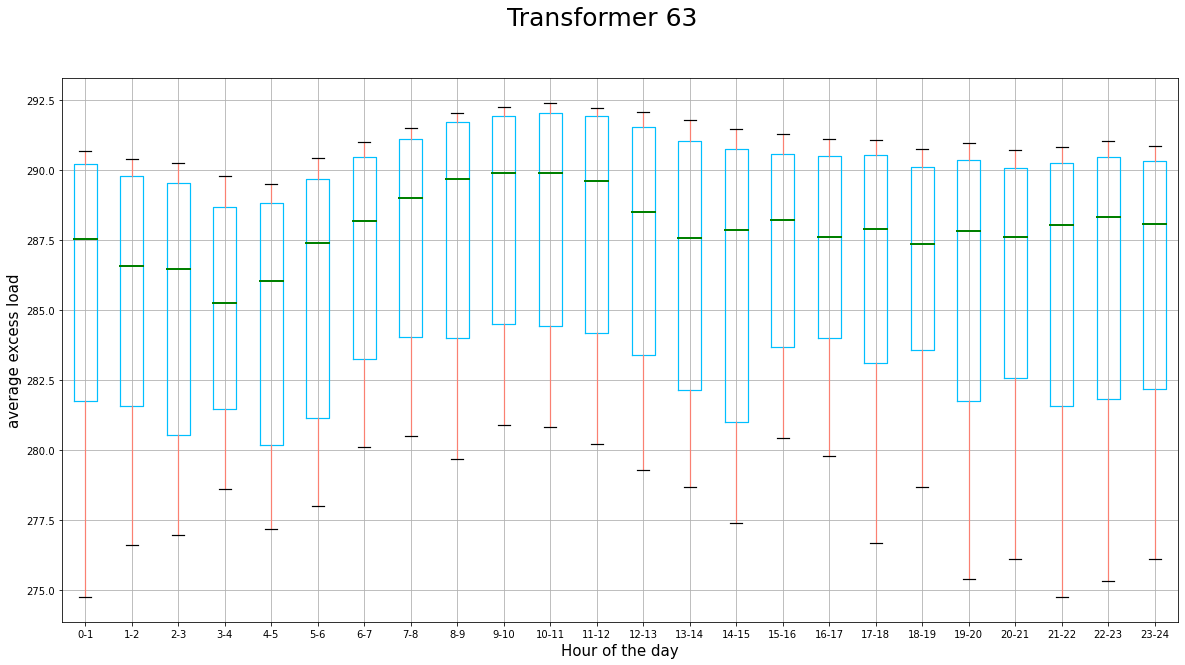

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))

data_63.groupby(data_63.index.hour).boxplot(column=["excess"], subplots=False,
            #color=dict(boxes='b', whiskers='b', medians='g', caps='r'),
            boxprops=dict(linestyle='-', linewidth=1.2, color = 'deepskyblue'),
            flierprops=dict(linestyle='-', linewidth=1.2, color = 'yellow'),
            medianprops=dict(linestyle='-', linewidth=2.0, color = 'green'),
            whiskerprops=dict(linestyle='-', linewidth=1.2, color = 'salmon'),
            capprops=dict(linestyle='-', linewidth=1.2, color='black'),
            showfliers=False, grid=True, rot=0)

xlabels = [f"{i}-{i+1}".format() for i in range(0,24)] 
plt.xlabel("Hour of the day", fontsize=15)  
plt.ylabel("average excess load", fontsize=15)
ax.set_xticks(range(1, 25))
ax.set_xticklabels(xlabels)
plt.suptitle("Transformer 63", fontsize=25)
plt.show()

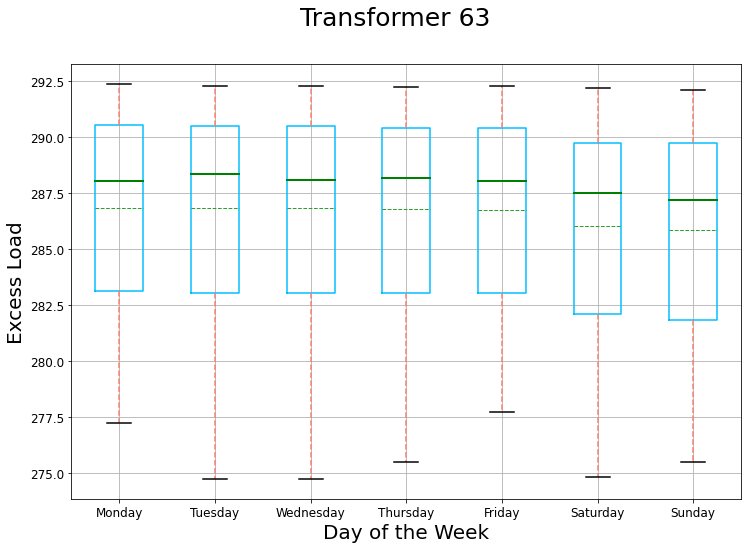

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

data_63.groupby(data_63.index.weekday).boxplot(column=["excess"], subplots=False, fontsize=12,
            # color=dict(boxes='r', whiskers='b', medians='g', caps='r'),
            boxprops=dict(linestyle='-', linewidth=1.5, color = 'deepskyblue'),
            flierprops=dict(linestyle='-', linewidth=1.5, color = 'yellow'),
            medianprops=dict(linestyle='-', linewidth=2.0, color = 'green'),
            whiskerprops=dict(linestyle='--', linewidth=1.5, color = 'salmon'),
            capprops=dict(linestyle='-', linewidth=1.5, color='black'),
            showfliers=False, grid=True, rot=0, showmeans=True, meanline=True)

days = list(calendar.day_name)
plt.xlabel("Day of the Week", fontsize=20)  
plt.ylabel("Excess Load", fontsize=20)
ax.set_xticks(range(1, 8))
ax.set_xticklabels(days)
plt.suptitle("Transformer 63", fontsize=25)
plt.show()

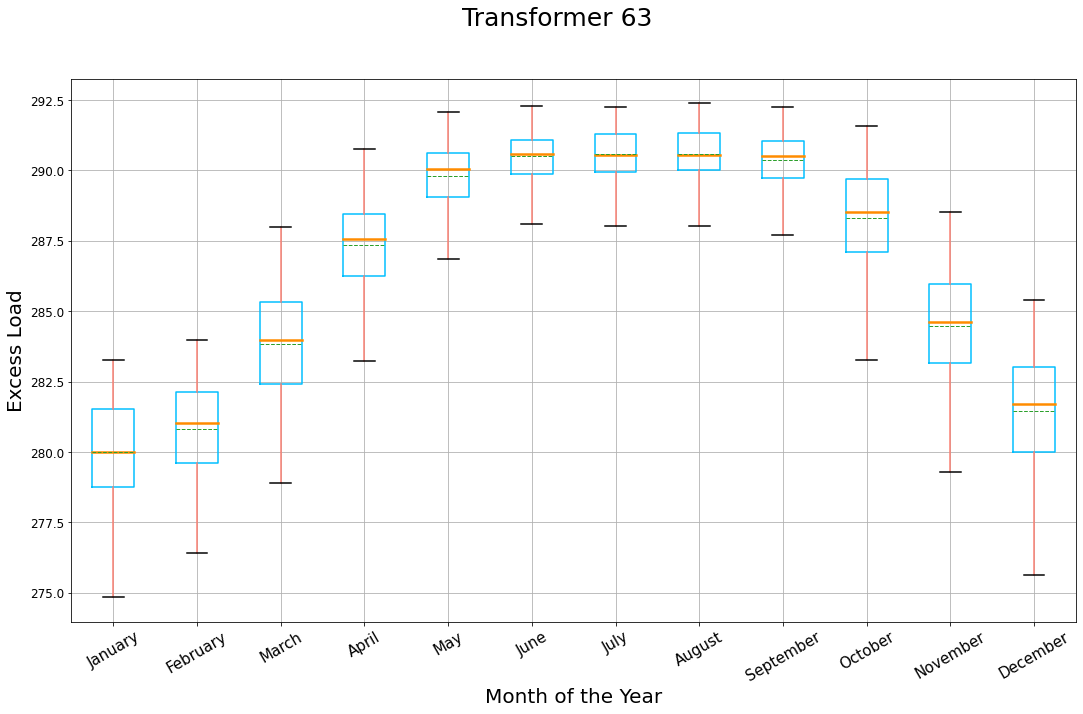

In [34]:
fig, ax = plt.subplots(figsize=(18, 10))

data_63.groupby(data_63.index.month).boxplot(column=["excess"], subplots=False, fontsize=12,
            # color=dict(boxes='r', whiskers='b', medians='g', caps='r'),
            boxprops=dict(linestyle='-', linewidth=1.5, color = 'deepskyblue'),
            flierprops=dict(linestyle='-', linewidth=1.5, color = 'yellow'),
            medianprops=dict(linestyle='-', linewidth=2.5, color = 'darkorange'),
            whiskerprops=dict(linestyle='-', linewidth=1.5, color = 'salmon'),
            capprops=dict(linestyle='-', linewidth=1.5, color='black'),
            showfliers=False, grid=True, rot=0, showmeans=True, meanline=True)

months = calendar.month_name[1:]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months, fontsize=15, rotation=30)
plt.xlabel("Month of the Year", fontsize=20)  
plt.ylabel("Excess Load", fontsize=20)

plt.suptitle("Transformer 63", fontsize=25)
plt.show()

In [35]:
parse_date_time(data_63)

,load,excess,weekday,year,month,day
timestamp,,,,,,
2021-01-01 08:00:00+00:00,12.478,281.522,Friday,2021,1,1
2021-01-01 09:00:00+00:00,11.904,282.096,Friday,2021,1,1
2021-01-01 10:00:00+00:00,12.103,281.897,Friday,2021,1,1
2021-01-01 11:00:00+00:00,11.460,282.540,Friday,2021,1,1
2021-01-01 12:00:00+00:00,12.690,281.310,Friday,2021,1,1
...,...,...,...,...,...,...
2021-12-30 20:00:00+00:00,17.253,276.747,Thursday,2021,12,30
2021-12-30 21:00:00+00:00,17.372,276.628,Thursday,2021,12,30
2021-12-30 22:00:00+00:00,16.014,277.986,Thursday,2021,12,30


### Heatmap of excess power load 

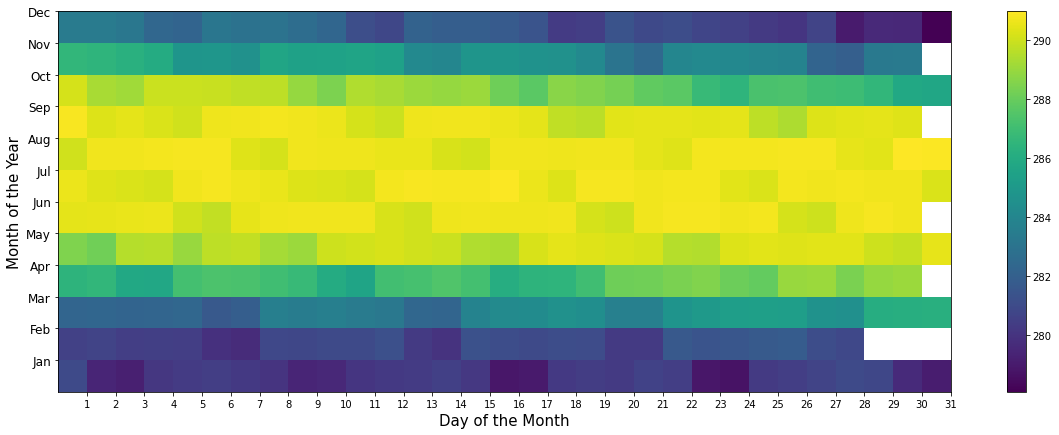

In [36]:
import seaborn as sns

pt = parse_date_time(data_63).pivot_table(index="month",columns="day",values="excess", aggfunc="mean")
#pt = pd.reindex_axis(months)
fig, ax = plt.subplots(figsize=(20,7))

im = ax.pcolormesh(pt, cmap="viridis")

plt.xlabel("Day of the Month", fontsize=15)  
plt.ylabel("Month of the Year", fontsize=15)
months_abbr = calendar.month_abbr[1:]
ax.set_yticks(range(1,13))
ax.set_yticklabels(months_abbr, fontsize=12, rotation=0)
ax.set_xticks(range(1,32))
ax.set_xticklabels(list(range(1,32)))

plt.colorbar(im)
plt.show()

As expected from previous analyses, the excess load is higher during the summer than winter. Also, it does not significantly vary with the day of the month.  

In [37]:
monthly_median = data_63.groupby(data_63.index.month).median()

,load,excess
timestamp,,
1,13.9985,280.0015
2,12.9695,281.0305
3,10.0335,283.9665
4,6.4540,287.5460
5,3.9675,290.0325
6,3.4245,290.5755
7,3.4625,290.5375
8,3.4480,290.5520
9,3.5000,290.5000


In [117]:

def charger_type():
    chargers = [int(item) for item in input("Enter the wattage of the chargers: ").split()]
    return chargers
chargers = charger_type()

cols = [f"Charger {i} : {c} kW" for i,c in zip(list(range(1, len(chargers)+1)), chargers)]

charger_dist = [get_charger_dist(chargers, excess_load, 67, 10) for excess_load in list(monthly_median["excess"])]
df_evc = pd.DataFrame(charger_dist, columns=cols, index=monthly_median.index)

df_evc_power = df_evc * np.array(chargers)

df_evc_power["Leftover Budgeted Capacity"] = monthly_median["excess"]*0.67 - df_evc_power.sum(axis=1)

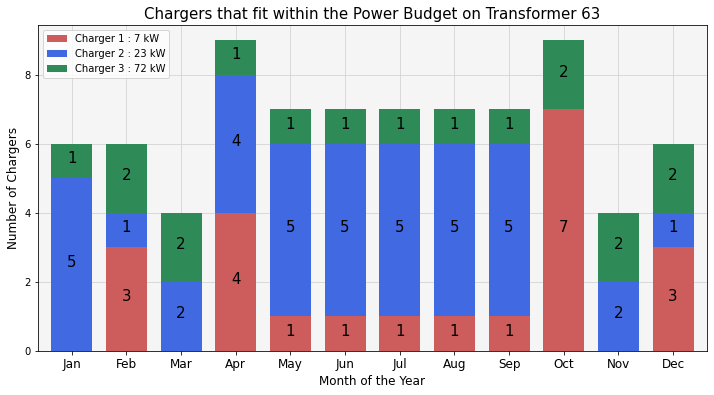

In [118]:
from operator import contains


fig, ax = plt.subplots(figsize=(12, 6))

df_evc.plot.bar(rot=0, width=0.75, ax=ax, fontsize=10, sort_columns=True, stacked=True, zorder=3, color=['indianred', 'royalblue', 'seagreen'])
# sns.barplot(data = df_evc, x = df_evc.index, y = df_evc.columns, palette = 'CMRmap', ax = ax)
months = calendar.month_abbr[1:]
ax.set_xlabel("Month of the Year", fontsize=12)  
ax.set_ylabel("Number of Chargers", fontsize=12)

ax.set_xticks(range(0, 12))
ax.set_xticklabels(months, fontsize=12, rotation=0)
for container in ax.containers:
    # Filter the labels
    labels = [int(v) if v > 0 else "" for v in container.datavalues]
    ax.bar_label(container, labels=labels, fmt="%d", fontsize=15, rotation=0, padding=3, label_type='center')

ax.grid(visible=True, axis='both', zorder=0, color='lightgrey')
ax.set_facecolor('whitesmoke')
ax.set_title("Chargers that fit within the Power Budget on Transformer 63", fontsize=15)

# df_evc_power.plot.bar(rot=0, width=0.5, ax=axs[1], fontsize=10, sort_columns=True, stacked=True, zorder=3)

# axs[1].set_xlabel("Month of the Year", fontsize=12)  
# axs[1].set_ylabel("Power Load by Chargers of Different Types", fontsize=12)

# axs[1].set_xticks(range(0, 12))
# axs[1].set_xticklabels(months, fontsize=12, rotation=0)
# for container in axs[1].containers:
#     labels = [int(v) if v > 0.99 else "" for v in container.datavalues]
#     axs[1].bar_label(container, labels=labels, fmt="%d", fontsize=10, rotation=0, padding=3, label_type='center')

# axs[1].grid(visible=True, axis='both', zorder=0, color='white')
# axs[1].set_facecolor('gainsboro')
# axs[1].set_title("Power Load of Chargers on Transformer 63", fontsize=15)

# axs[1].legend(df_evc.columns, loc=1)

plt.show()

If we adapt the most common distribution we get that the max load from the EVCs are $3\times 7 + 2\times 19 + 2\times 72 = 203$.  

In [115]:
def plot_charger_dist(data, percent=67, max_num=10):
    chargers = charger_type()
    monthly_median = data.groupby(data.index.month).median()
    cols = [f"Charger {i} : {c} kW" for i,c in zip(list(range(1, len(chargers)+1)), chargers)]

    charger_dist = [get_charger_dist(chargers, excess_load, percent, max_num) for excess_load in list(monthly_median["excess"])]
    df_evc = pd.DataFrame(charger_dist, columns=cols, index=monthly_median.index)

    # df_evc_power = df_evc * np.array(chargers)

    # df_evc_power["Leftover Budgeted Capacity"] = monthly_median["excess"]* (percent/100) - df_evc_power.sum(axis=1)

    fig, ax = plt.subplots(figsize=(12, 6))

    df_evc.plot.bar(rot=0, width=0.75, ax=ax, fontsize=10, sort_columns=True, stacked=True, zorder=3, color=['indianred', 'forestgreen', 'dodgerblue'])
# sns.barplot(data = df_evc, x = df_evc.index, y = df_evc.columns, palette = 'CMRmap', ax = ax)
    months = calendar.month_abbr[1:]
    ax.set_xlabel("Month of the Year", fontsize=12)  
    ax.set_ylabel("Number of Chargers", fontsize=12)

    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(months, fontsize=12, rotation=0)
    for container in ax.containers:
    # Filter the labels
        labels = [int(v) if v > 0 else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, fmt="%d", fontsize=15, rotation=0, padding=3, label_type='center')

    ax.grid(visible=True, axis='both', zorder=0, color='lightgrey')
    ax.set_facecolor('whitesmoke')
    ax.set_title("Chargers that fit within the Power Budget on Transformer 63", fontsize=15)

    return fig, ax
    

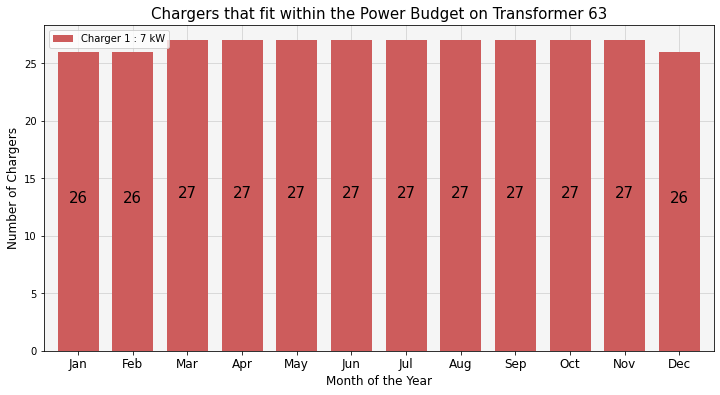

In [116]:
fig , ax = plot_charger_dist(data_63, percent=67, max_num=100)

In [ ]:
monthly_min = data_63.groupby(data_63.index.month).min()
monthly_max = data_63.groupby(data_63.index.month).max()

monthly = pd.DataFrame(index=monthly_median.index)

monthly["max_percent_util"] = (203*100)/monthly_min["excess"]
monthly["min_percent_util"] = (203*100)/monthly_max["excess"]
monthly["median_percent_util"] = (203*100)/monthly_median["excess"]

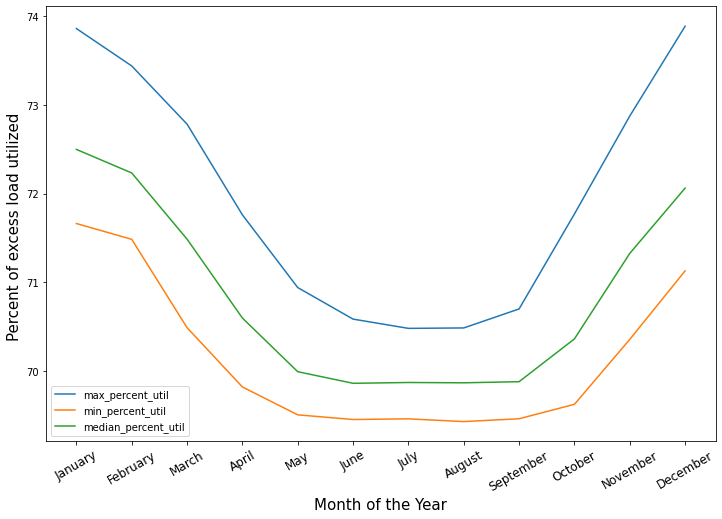

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
monthly.plot(ax=ax)

months = calendar.month_name[1:]
plt.xlabel("Month of the Year", fontsize=15)  
plt.ylabel("Percent of excess load utilized ", fontsize=15)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(months, fontsize=12, rotation=30)
# for container in ax.containers:
#     ax.bar_label(container, fmt="%d", fontsize=15, rotation=0, padding=3, label_type='center')
#plt.suptitle("Number of EvCs of Different Type based on Monthly Average Data for Transformer 63", fontsize=20)

plt.show()